#  Masking Pipeline

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)


In [13]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask)
from chxanalys.chx_libs import cmap_albula, cmap_vge, random
from chxanalys.chx_generic_functions import (get_detector, get_meta_data,create_user_folder,
                                             get_fields,  get_sid_filenames,load_data,
                                             RemoveHot, show_img,get_avg_img, 
                                             reverse_updown,create_cross_mask,mask_badpixels )
from skimage.draw import line_aa, line, polygon, circle
 
%matplotlib notebook

# Path for Saving Results

In [14]:
CYCLE= '2017_3'  #change clycle here

In [15]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2017_3/masks/


### Get the image series and metadata from the uid

In [24]:
uid =  '35159a' # (scan num: 7828) (Measurement: 750Hz 10k CoralPor )'
uid = '89ac4a'  # (scan num: 7822) (Measurement: 750Hz 2k CoralPor )



In [25]:
md = get_meta_data( uid )
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])

print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  7822--89ac4a54-1082-479f-a22d-fce629b4cfd9--/XF11ID/data/2017/10/13/5b25fdb8-baeb-4f80-ab17_1964


In [26]:
print(md['beam_center_y'], md['beam_center_x'])

1236.0 1121.0


In [27]:
imgs = load_data( uid, detector, reverse= False  )
#imgs = load_data( uid, detector, reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 2000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [28]:
pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [29]:
img_choice_N = 1  #can change this number to select more frames for average
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgs, img_samp_index, plot_ = False, uid = uid)

## show image and the pixel mask

* show image

<IPython.core.display.Javascript object>


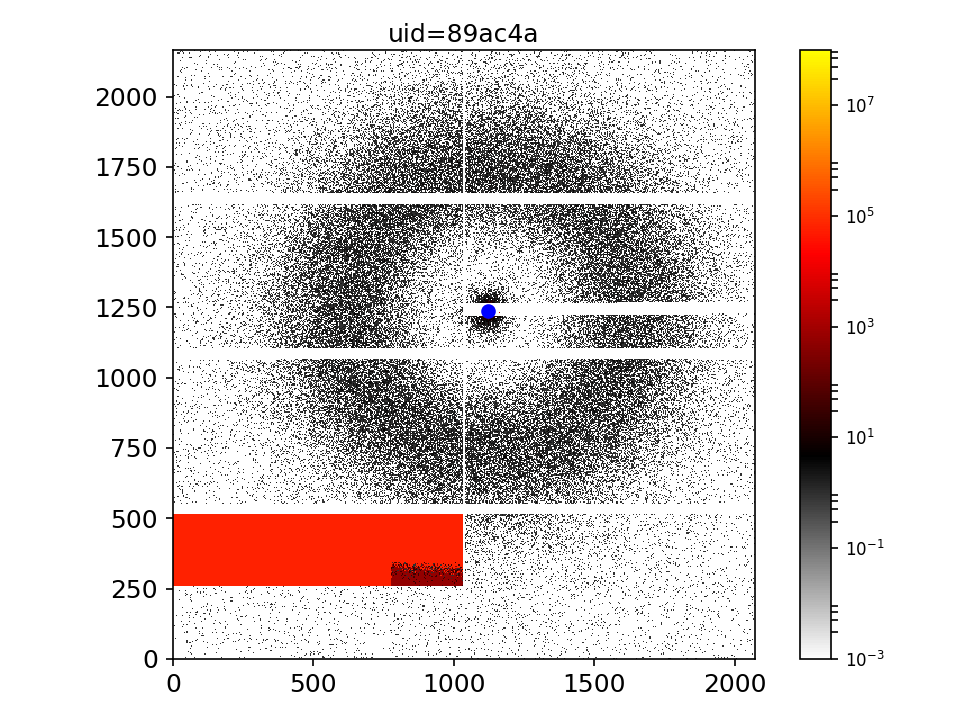

/opt/conda_envs/analysis/lib/python3.5/site-packages/matplotlib/colorbar.py:821: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  y[self._inside] = norm(yi)


In [30]:
show_img(  avg_img*pixel_mask , vmin=.001, vmax=1e8, logs=True, 
         image_name ='uid=%s'%uid, aspect=1, cmap= cmap_albula, 
         center = [md['beam_center_x'], md['beam_center_y']]  )


* pixel mask

### Update Pixel Mask due to bad pixel of Eiger Detector

In [31]:
pixel_mask = mask_badpixels( pixel_mask, md['detector'])

<IPython.core.display.Javascript object>


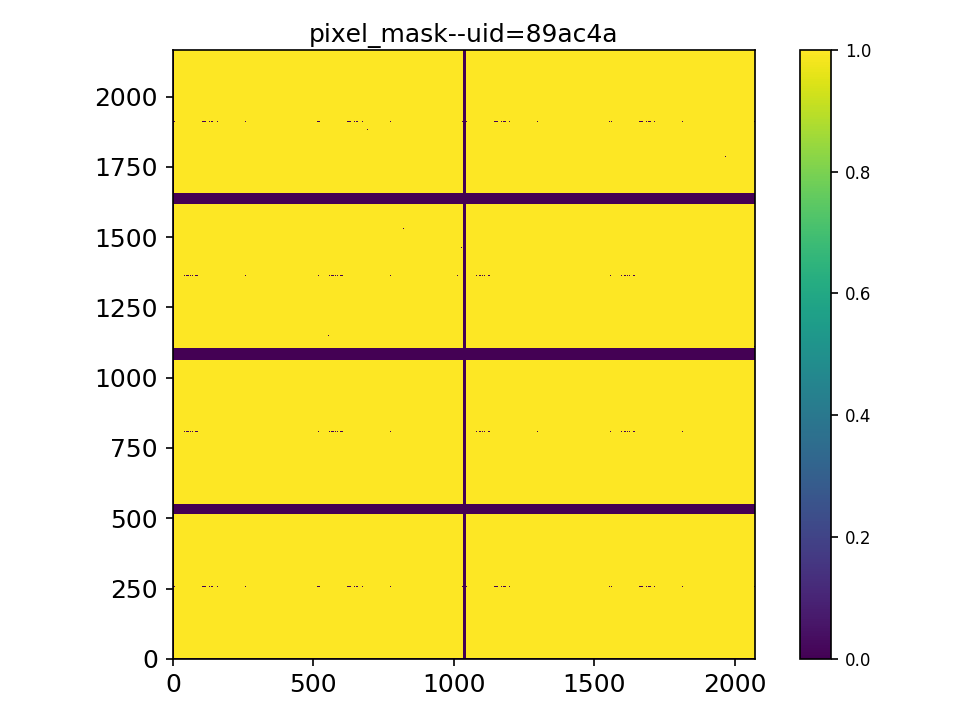

In [32]:
show_img( pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid ,aspect=1 )

## Remove hotspots in the image

In [33]:
#avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


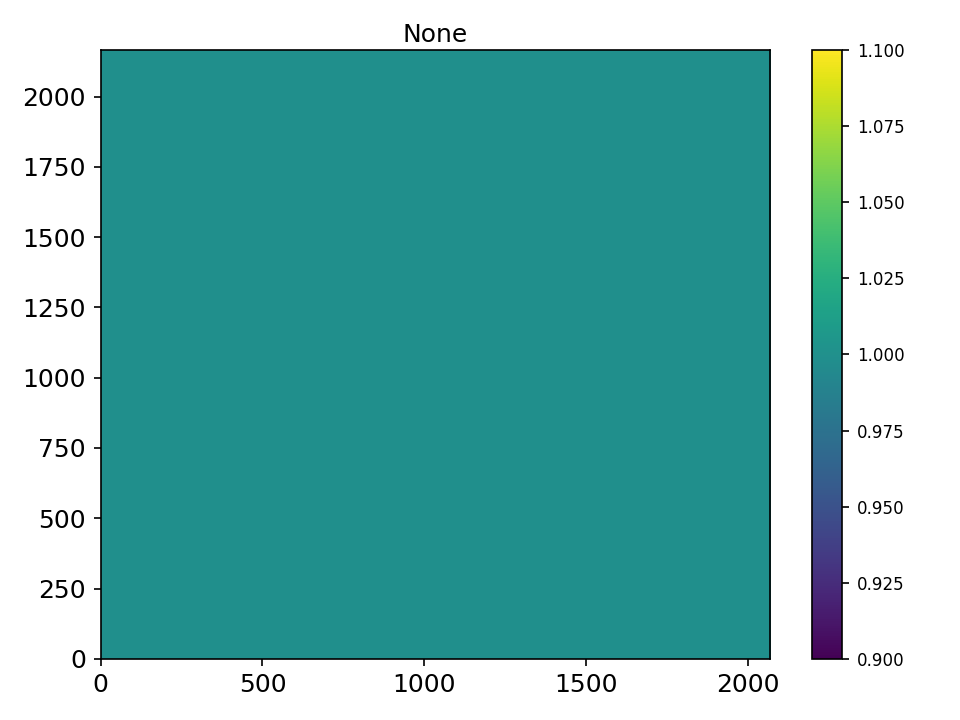

In [34]:
mask_rh  = RemoveHot( avg_img, 2**20-1, plot_=True)

<IPython.core.display.Javascript object>


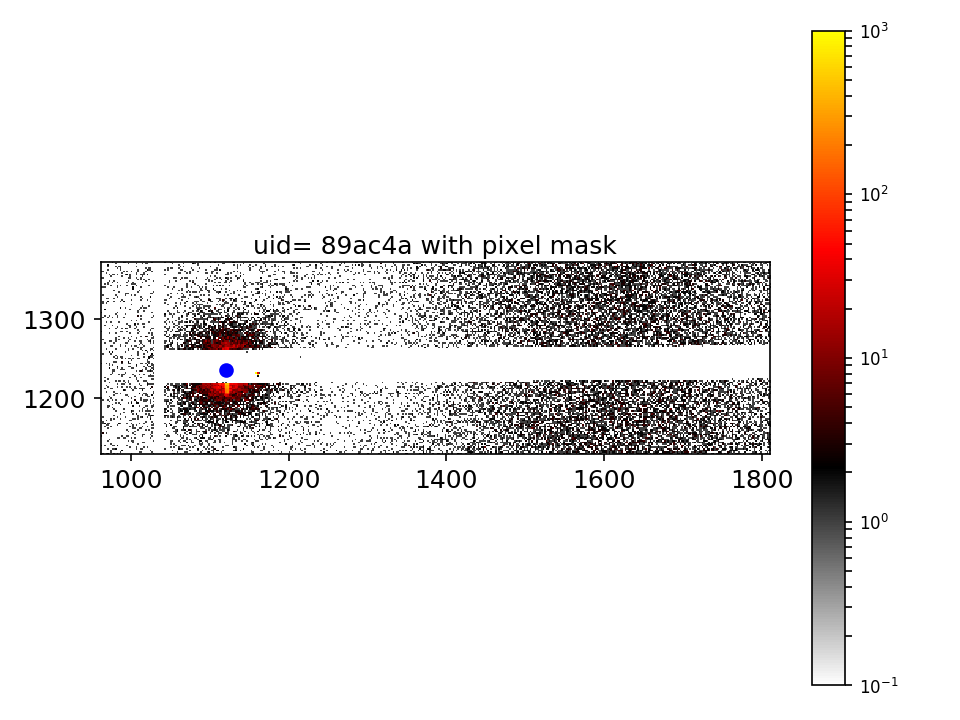

/opt/conda_envs/analysis/lib/python3.5/site-packages/matplotlib/colorbar.py:821: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  y[self._inside] = norm(yi)


In [36]:
show_img(avg_img*pixel_mask,vmin=0.1,vmax=1e3, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula,
         center = [md['beam_center_x'], md['beam_center_y']]  )

# Create a polygon mask

* check beam center

In [41]:
md['beam_center_x'], md['beam_center_y']

(1121.0, 1236.0)

### To create multi-rectangle masks, for each sub-mask



In [38]:
path

'/XF11ID/analysis/2017_3/masks/'

In [42]:
#creat the right part mask
partial_mask = create_cross_mask(  avg_img,center=[1030,1236],
                            wy_left= 0, wy_right= 25, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

<IPython.core.display.Javascript object>


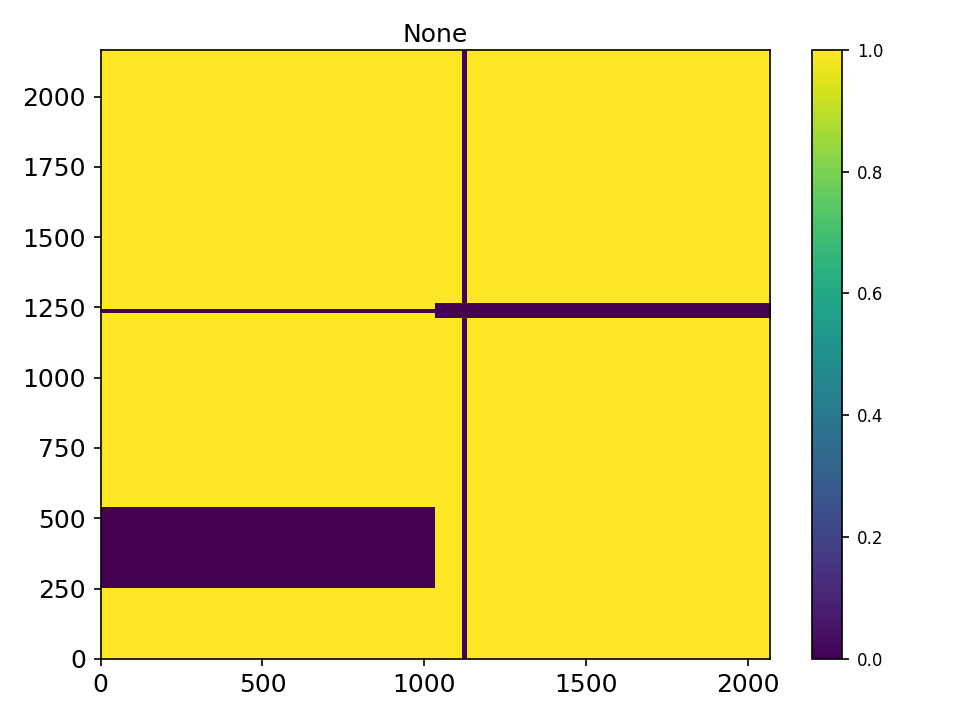

In [43]:
show_img(  partial_mask   )

In [45]:
#np.save( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop', partial_mask )
#Ver_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Ver_Beamstop.npy' )
#Ver_Beamstop = move_beamstop( Vertical_Beamstop, xshift=0, yshift=0 )

In [45]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[  1121.0, 1236.0 ],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 8, wx_down=8,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [46]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1146,680],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [47]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1139,1225],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [48]:
#from chxanalys.chx_generic_functions import create_multi_rotated_rectangle_mask

In [49]:
#np.save( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop', partial_mask )
#Hor_Beamstop = np.load( '/XF11ID/analysis/2017_1/masks/Hor_Beamstop.npy' )
#Hor_Beamstop = move_beamstop( Hor_Beamstop, xshift=0, yshift=0 )

<IPython.core.display.Javascript object>


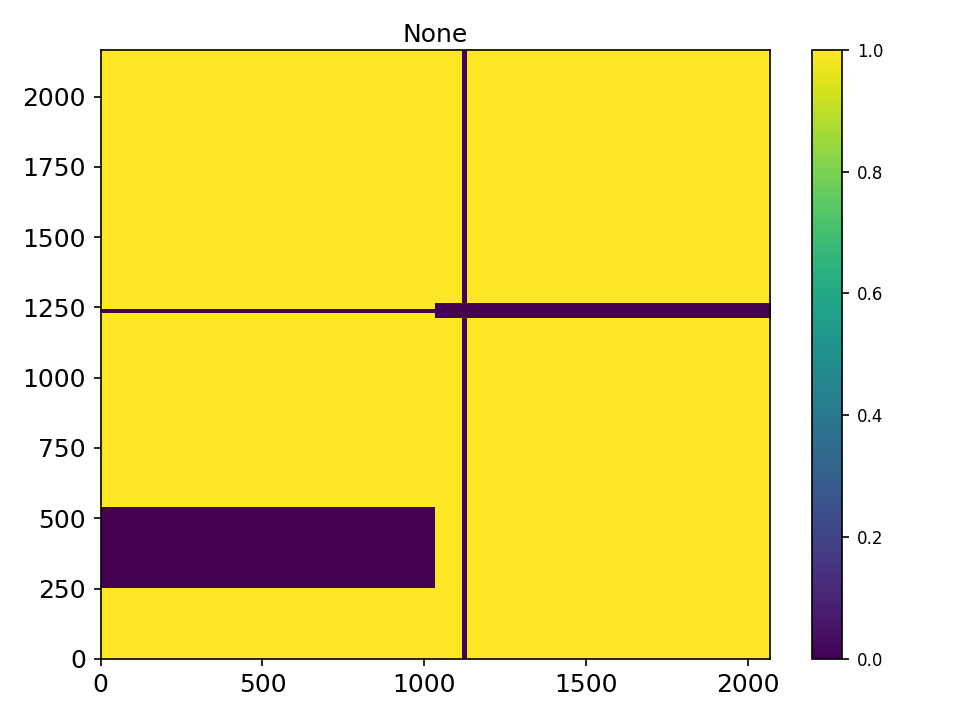

In [50]:
show_img(  partial_mask   )

In [51]:
#creat the left/right/up/down part mask
#partial_mask *=  create_cross_mask(  avg_img, center=[ 1615,2000],
#                            wy_left= 0, wy_right= 100, 
#                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

In [52]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1030,395],
                            wy_left= 145, wy_right= 0, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )


In [53]:
#np.save( '/XF11ID/analysis/2017_1/masks/Bad_4M', partial_mask )
#Bad_4M = np.load( '/XF11ID/analysis/2017_1/masks/Bad_4M.npy' )
 

In [54]:
#create a circle mask for windows
if False: #make it True to make window mask
    window_shadow  = ~create_cross_mask(  avg_img, center=[ 911,997],
                           wy_left= 0, wy_right= 0, 
                             wx_up= 0, wx_down= 0,center_circle=True, center_radius= 680)
else:
    window_shadow = 1

In [55]:
full_mask = partial_mask *window_shadow
#full_mask = Ver_Beamstop * Hor_Beamstop *Bad_4M *window_shadow

<IPython.core.display.Javascript object>


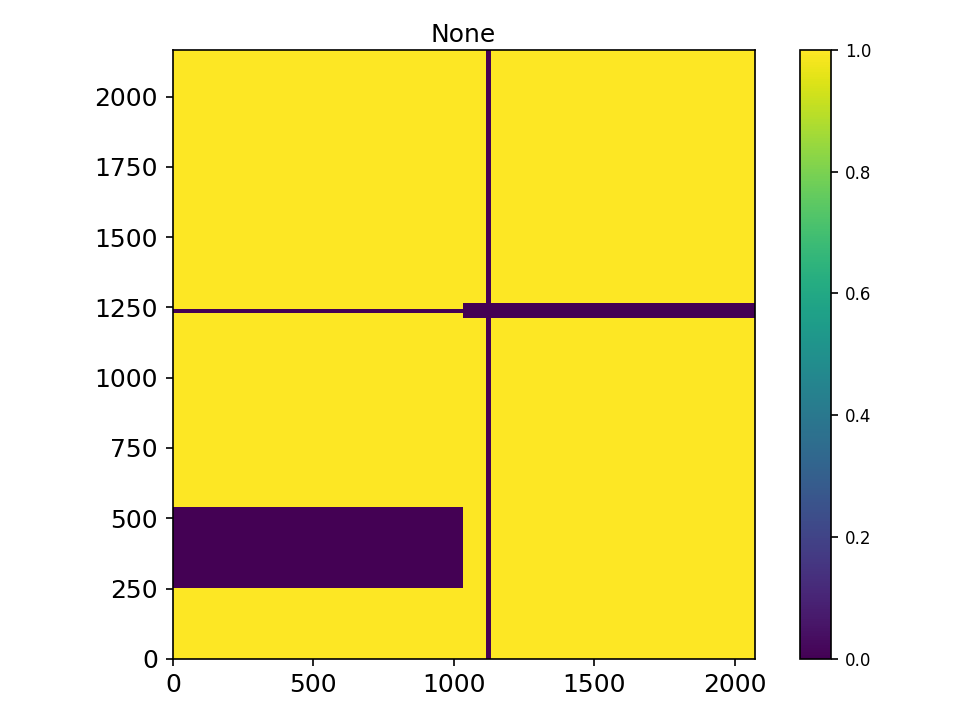

In [56]:
show_img( full_mask, aspect = 1 )

In [57]:
mask = np.array ( full_mask * pixel_mask*mask_rh  , dtype = bool )
#mask = np.array ( full_mask * pixel_mask , dtype = bool )

<IPython.core.display.Javascript object>


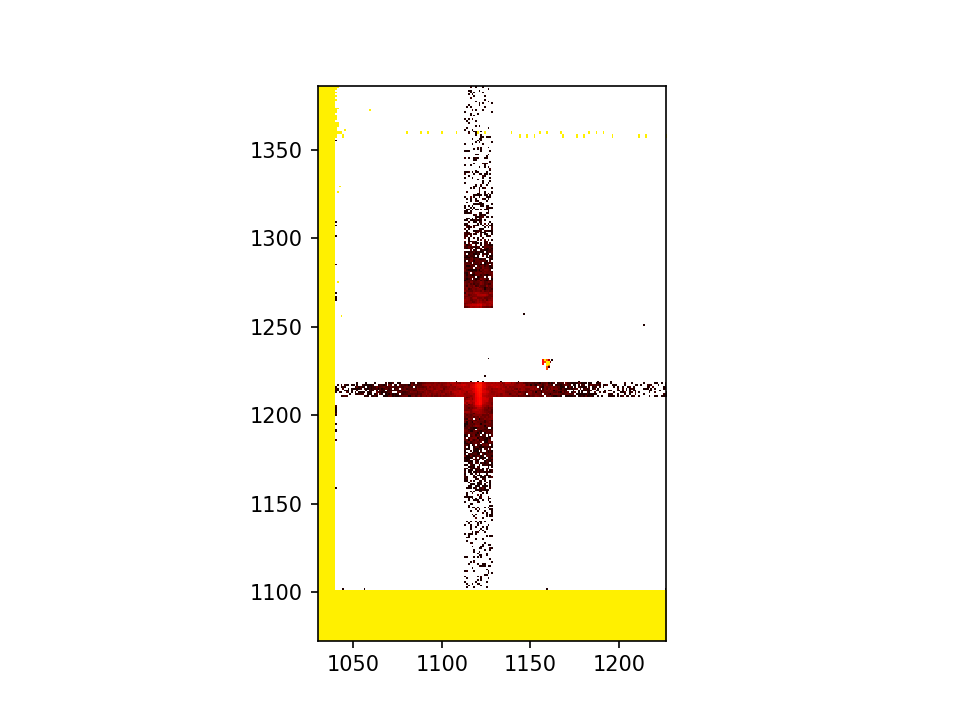

In [58]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax= 1e5), cmap= cmap_albula)
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


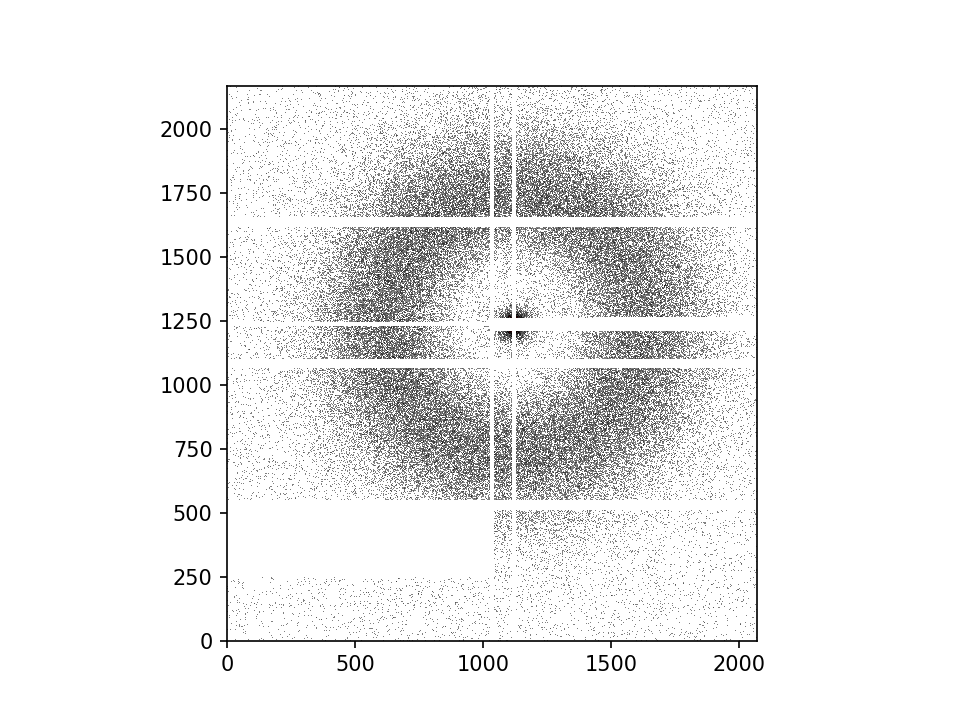

In [59]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap= cmap_albula,origin='lower',norm= LogNorm( vmin=.1, vmax=1e5 ),
               interpolation='none')
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


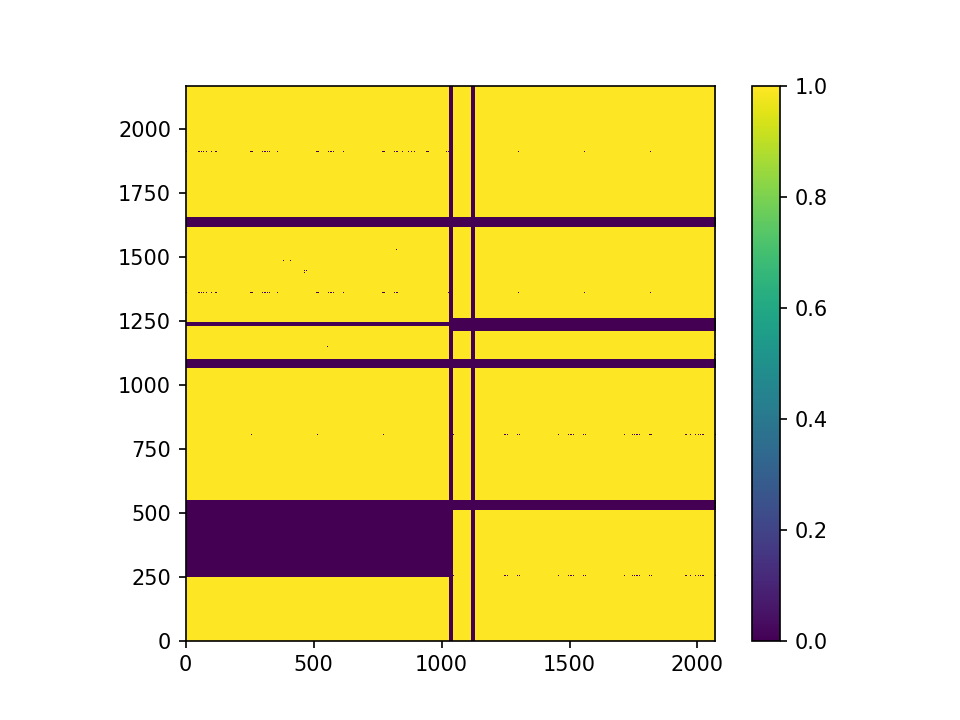

In [60]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [61]:
np.save(  path +   uid +"_mask", mask)

In [62]:
path +   uid +"_mask"

'/XF11ID/analysis/2017_3/masks/89ac4a_mask'

#### save with a meaningful filename, make False after excute to avoid overwrite

In [65]:
if False:
    meaningful_name = 'Octo13_SAXS' 
    np.save(  path +   meaningful_name, mask)
    print( path +   meaningful_name )

In [66]:
path +   meaningful_name

'/XF11ID/analysis/2017_3/masks/Octo13_SAXS'

In [67]:
uid

'89ac4a'